# Dataplex Universal Catalog and Open Lineage Workshop

**Overview**: The purpose of this workshop is to show how to use the processOpenLineageRunEvent API to create an open lineage event for Dataplex Universal Catalog.  This (documentation)[https://cloud.google.com/dataplex/docs/open-lineage] shows how to map OpenLineage events to the Dataplex API and also shows an example.

This notebook will generate synthetic data using the 'faker' python package in a CSV file, load this data to GCS and then to BigQuery.  Also, a Dataplex Universal Catalog (DUC) Entry will be created for the CSV file so that we can visualize the lineage in the DUC.

The processOpenLineageRunEvent API will be called to create the lineage event.

**Process Flow:**

1.  Create CSV File using Faker.
2.  Load CSV File to GCS.
3.  Load GCS CSV File to BigQuery Table
4.  Create D.U.C Entry
5.  Call processOpenLineageRunEvent API

Notes:
* TBD.

Cost:
* Approximate cost: Less than 1 dollar

Author:
* Jay O'Leary

# License

```
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```

# Prerequisites



- Use an existing project or create a new one <BR>
- Use an existing VPC or create a new one as follows:<BR>
<B>[You can run the following from Cloud Shell]</B>
```
VPC_NAME=default
GCP_PROJECT_ID=$(gcloud config get project)
gcloud compute networks create $VPC_NAME \
--project=$GCP_PROJECT_ID \
--subnet-mode=custom \
--mtu=1460 \
--bgp-routing-mode=regional
```
<BR>
- Create Subnet as follows: <BR>

```
SUBNET_CIDR=10.0.0.0/16
SUBNET_NAME=default
VPC_NAME=default
GCP_PROJECT_ID=$(gcloud config get project)
LOCATION=us-central1
gcloud compute networks subnets create $SUBNET_NAME \
 --network $VPC_NAME \
 --range $SUBNET_CIDR  \
 --region $LOCATION \
 --enable-private-ip-google-access \
 --project $GCP_PROJECT_ID
```
<BR>
- Create firewall rules as follows:

```
VPC_NAME=default
gcloud compute firewall-rules create allow-pypi-outbound \
    --network=$VPC_NAME \
    --action=ALLOW \
    --direction=EGRESS \
    --rules=tcp:443 \
    --destination-ranges=0.0.0.0/0
```

<BR>
- Create Router and NAT Gateway as follows:<BR>

```
VPC_NAME=default
LOCATION=us-central1
gcloud compute routers create router-for-nat \
    --network=$VPC_NAME \
    --region=$LOCATION

gcloud compute routers nats create notebook-nat-gateway \
    --router=router-for-nat \
    --region=$LOCATION \
    --nat-all-subnet-ip-ranges \
    --auto-allocate-nat-external-ips
```
<BR>

- enable dataplex api's

gcloud services enable datalineage.googleapis.com

# Pip Installs

In [ ]:
!pip install Faker

# Initialize

In [ ]:
from google.cloud import storage
import subprocess
import json
import csv
from faker import Faker
import uuid

#Declare some variables
GCP_PROJECT_ID  = ! gcloud config get project
GCP_PROJECT_ID  = GCP_PROJECT_ID[0]
PROJECT_NUMBER  = !gcloud projects describe {GCP_PROJECT_ID} | grep projectNumber | cut -d':' -f2 |  tr -d "'" | xargs
PROJECT_NUMBER  = PROJECT_NUMBER[0]
GCP_LOCATION    = "us-central1"
DATASET_NAME    = "openlineage_demo"
TABLE_NAME      = "csv2bq"
BUCKET_NAME     = f"openlineage-demo-{PROJECT_NUMBER}"
# Dataplex Data Lineage API endpoint
DATAPLEX_API_URL=f"https://datalineage.googleapis.com/v1/projects/{GCP_PROJECT_ID}/locations/{GCP_LOCATION}:processOpenLineageRunEvent"
# An OpenLineage namespace for your jobs
OPENLINEAGE_NAMESPACE="bash-scripts-dataplex"
# A unique run ID for this job execution
RUN_ID=uuid.uuid4()
# The name of the fake data file
DATA_FILE=f"faux_data_{RUN_ID}.csv"
# The Name of the custom entry group
ENTRY_GROUP_NAME="lineage-test-entry-group"
# The Name of the custom entry
ENTRY_NAME="lineage-test-entry"
# The Name of the custom entry type
ENTRY_NAME_TYPE="lineage-test-entry-type"
DATASET_SQL = f"create schema {DATASET_NAME}"
VPC_NAME="default"

storage_client = storage.Client(project=GCP_PROJECT_ID)


# Helper Methods

In [ ]:
def restAPIHelper(url: str, http_verb: str, request_body: str) -> str:
  """Calls the Google Cloud REST API passing in the current users credentials"""

  import google.auth.transport.requests
  import requests
  import google.auth
  import json

  # Get an access token based upon the current user
  creds, project = google.auth.default()
  auth_req = google.auth.transport.requests.Request()
  creds.refresh(auth_req)
  access_token=creds.token

  headers = {
    "Content-Type" : "application/json",
    "Authorization" : "Bearer " + access_token
  }

  if http_verb == "GET":
    response = requests.get(url, headers=headers)
  elif http_verb == "POST":
    response = requests.post(url, json=request_body, headers=headers)
  elif http_verb == "PUT":
    response = requests.put(url, json=request_body, headers=headers)
  elif http_verb == "PATCH":
    response = requests.patch(url, json=request_body, headers=headers)
  elif http_verb == "DELETE":
    response = requests.delete(url, headers=headers)
  else:
    raise RuntimeError(f"Unknown HTTP verb: {http_verb}")

  if response.status_code == 200:
    return json.loads(response.content)
    #image_data = json.loads(response.content)["predictions"][0]["bytesBase64Encoded"]
  else:
    error = f"Error restAPIHelper -> ' Status: '{response.status_code}' Text: '{response.text}'"
    raise RuntimeError(error)

In [ ]:
#create bucket if it does not exist
def create_storage_bucket():
  buckets = storage_client.list_buckets()
  bucket_names = [bucket.name for bucket in buckets]

  bucket = storage_client.bucket(BUCKET_NAME)

  if not bucket.exists():
      try:
          bucket = storage_client.create_bucket(BUCKET_NAME)
          print(f"Bucket {bucket.name} created.")
      except Exception as e:
          print(f"Error creating bucket: {e}")
  else:
      print(f"Bucket {BUCKET_NAME} already exists.")

create_storage_bucket()

In [ ]:
def create_entry():
  #create dataplex universal catalog entry group
  !gcloud dataplex entry-groups create {ENTRY_GROUP_NAME} --location={GCP_LOCATION}

  #create dataplex universal catalog entry type
  !gcloud dataplex entry-types create {ENTRY_NAME_TYPE} --location={GCP_LOCATION}

  #create dataplex universal catalog entry
  cmd=f"""
  gcloud dataplex entries create "{ENTRY_NAME}-{RUN_ID}" \
              --location={GCP_LOCATION} \
              --entry-group={ENTRY_GROUP_NAME} \
              --entry-type=projects/{GCP_PROJECT_ID}/locations/{GCP_LOCATION}/entryTypes/{ENTRY_NAME_TYPE} \
              --fully-qualified-name="gcs:{BUCKET_NAME}.\`{DATA_FILE}\`"
  """
  !{cmd}




# Create CSV & Create Dataplex Universal Catalog Entry

In [ ]:
#create synthetic data
import csv
from faker import Faker

# 1. Initialize Faker
# Create a Faker instance, optionally setting a locale (e.g., 'en_US')
fake = Faker('en_US')
# Optional: Set a seed for reproducible data generation
Faker.seed(42)

# --- Configuration ---
NUM_RECORDS = 100
FIELDNAMES = ['id', 'first_name', 'last_name', 'email', 'date_of_birth', 'address']
OUTPUT_FILE = 'synthetic_users.csv'

# --- Data Generation Function ---
def create_fake_user(user_id):
    """Generates a single dictionary representing a synthetic user record."""
    return {
        'id': user_id,
        'first_name': fake.first_name(),
        'last_name': fake.last_name(),
        'email': fake.email(),
        'date_of_birth': fake.date_of_birth(minimum_age=18, maximum_age=65),
        'address': fake.street_address() + ', ' + fake.city() + ', ' + fake.postcode()
    }

# --- Write to CSV ---
print(f"Generating {NUM_RECORDS} records and writing to {DATA_FILE}...")

with open(DATA_FILE, 'w', newline='', encoding='utf-8') as csvfile:
    # Create a DictWriter object
    writer = csv.DictWriter(csvfile, fieldnames=FIELDNAMES)

    # Write the header row
    writer.writeheader()

    # Write the data rows
    for i in range(1, NUM_RECORDS + 1):
        writer.writerow(create_fake_user(i))

print(f"CSV file '{DATA_FILE}' successfully created.")

#load csv file to gcs storage
storage_client.bucket(BUCKET_NAME).blob(DATA_FILE).upload_from_filename(DATA_FILE)
print(f"CSV file '{DATA_FILE}' loaded to GCS Bucket '{BUCKET_NAME}'.")



In [ ]:
#create the Dataplex Universal Catalog Entry
create_entry()

# Load CSV to BigQuery

In [ ]:
%%bigquery
$DATASET_SQL


In [ ]:
#load file into bq table
table_id = f"{DATASET_NAME}.{TABLE_NAME}-{RUN_ID}"
cmd=f"bq load --source_format=CSV --autodetect {table_id} gs://{BUCKET_NAME}/{DATA_FILE}"
!{cmd}
print(f"Created table '{table_id}' in dataset '{DATASET_NAME}'")

# Create Lineage Event

In [ ]:

request_body = {
    "eventTime": "2025-08-09T08:25:36.098Z",
    "eventType": "COMPLETE",
    "job": {
        "name": "create-faux-data",
        "namespace": "custom"
    },
    "inputs": [
        {
            "name": f"/downloads/{DATA_FILE}",
            "namespace": "file://local:"
        }
    ],
    "outputs": [
        {
            "name": f"{DATA_FILE}",
            "namespace": f"gs://{BUCKET_NAME}"
        }
    ],
    "producer": "faker",
    "run": {
        "runId": f"{RUN_ID}"
    },
    "schemaURL":"https://openlineage.io/spec/1-0-5/OpenLineage.json#/$defs/RunEvent"
}
print(request_body)
json_response = restAPIHelper(DATAPLEX_API_URL, "POST", request_body)
print(json_response)




In [ ]:
import re
#extract process id
pattern = r"'process': '.*?/processes/([\w-]+)'"
match = re.search(pattern, str(json_response))
if match:
    process_id = match.group(1)
    print(process_id)
else:
    print("Process ID not found in the string.")

#extract run id
pattern = r"'run': '.*?/runs/([\w-]+)'"
match = re.search(pattern, str(json_response))
if match:
    run_id = match.group(1)
    print(run_id)
else:
    print("Run ID not found in the string.")


# Browse Dataplex Universal Catalog

In [ ]:
print(f"Click on this url to view new entries in the Dataplex Universal Catalog.")
print(f"link: https://console.cloud.google.com/dataplex/dp-search?project={GCP_PROJECT_ID}&q={RUN_ID}")

You should see two results similar to entries similar to the list below:
<BR>

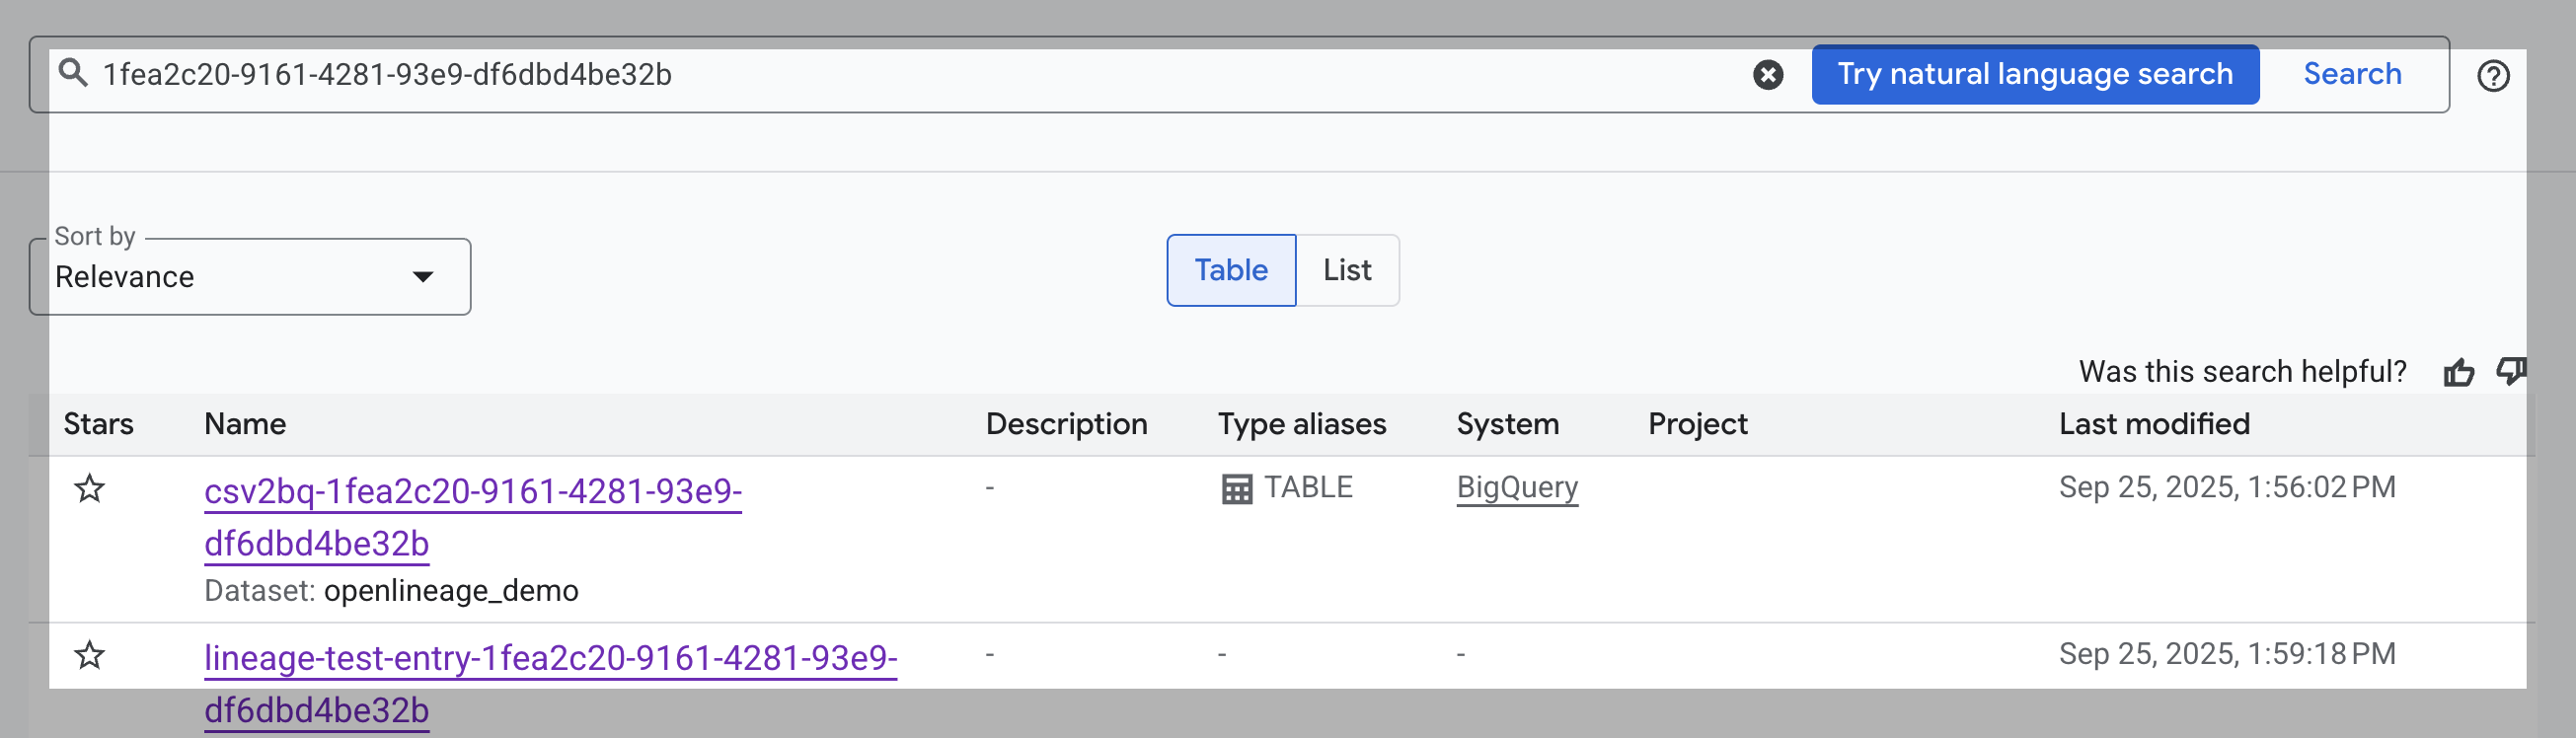

<BR>